In [725]:
import urllib.request
import urllib,os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np

download=False
the_file='case_60_10.nc'
the_url="http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}".format(the_file)
if download:
    out=urllib.request.urlretrieve(the_url,the_file)
    print(out)
print("download {}: size is {:8.4g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))

download case_60_10.nc: size is    499.3 Mbytes


In [726]:
!ncdump -h case_60_10.nc

netcdf case_60_10 {
dimensions:
	time = 48 ;
	x = 25 ;
	y = 20 ;
	z = 130 ;
variables:
	float time(time) ;
		string time:units = "minutes" ;
	float x(x) ;
		string x:units = "meters" ;
	float y(y) ;
		string y:units = "meters" ;
	float z(z) ;
		string z:units = "meters" ;
	float press(z) ;
		string press:units = "Pa" ;

// global attributes:
		:heat_flux_W_m2 = 100L ;
		:gamma_K_km = 10L ;

group: c1 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c1

group: c2 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c2

group: c3 {
  variables:
  	float TABS(time, z, y, x) ;
  

In [778]:
# extract all variables needed from case_60_10.nc


import matplotlib.pyplot as plt

%matplotlib inline

def make_theta(temp,press):
    """
      temp in K
      press in Pa
      returns theta in K
    """
    p0=1.e5
    Rd=287.
    cpd=1004.
    theta=temp*(p0/press)**(Rd/cpd)
    return theta

case_name='case_60_10.nc'
ensemble='c1'
with Dataset(case_name,'r') as ncin:
    group = ncin.groups['c1']
    temp=group.variables['TABS'][...]
    press=ncin.variables['press'][...]
    uvel =group.variables['U'][...]
    vvel =group.variables['V'][...]
    wvel =group.variables['W'][...]
    z = ncin.variables['z'][...]
    y = ncin.variables['y'][...]
    x = ncin.variables['x'][...]
tempprof=temp.mean(axis=3).mean(axis=2)



In [728]:
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np

# Create class IntegPM

class IntegPM(Integrator):
    
    # add uvel,vvel, wvel, and new x,y,z arrays into set_initt

    def set_yinit(self,uvel,vvel,wvel,newx,newy,newz):
        #
        # read in 'mean wind speed - not doing this yet'
        #
        self.config["initvars"]["initialx"]=newx
        self.config["initvars"]["initialy"]=newy
        self.config["initvars"]["initialz"]=newz
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'initial locations'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.initialx, self.initvars.initialy, self.initvars.initialz])
        self.nvars = len(self.yinit)
        self.uvel = uvel
        self.vvel = vvel
        self.wvel = wvel
        return None

    def __init__(self, coeff_file_name,uvel,vvel,wvel,newx,newy,newz):
        super().__init__(coeff_file_name)
        self.set_yinit(uvel,vvel,wvel,newx,newy,newz)
        
        # code up interpolation scheme
        
    def getvel(self,ti,zz,yy,xx,vels):
        #produces an averaged velocity for values between 
        #data points 
    
        # Args:
        #   t- time variable
        #   x,y,z - decimal spacial coordinates 
        #   vel - the velocity field, one of:
        #   uvel, vvel, wvel
        # Returns:
        #   the new velicities in the u,v,w.
    

        # sort out the x variables
        xtop  = np.ceil(xx)
        xbot  = np.floor(xx)
        txdif = xx - xbot
    
        # sort out the y variables
    
        ytop  = np.ceil(yy)
        ybot  = np.floor(yy)
        tydif = yy - ybot
    
        # sort out the z variables
        ztop  = np.ceil(zz)
        zbot  = np.floor(zz)
        tzdif = zz - zbot
        
        #ti = 0
    
        # calculate average velocity at any given piont
        
  
        uA = (vels[ti,ztop,ytop,xtop]*(1.-tzdif)*(1.-tydif)*(1.-txdif))
        uB = (vels[ti,ztop,ybot,xbot]*(1.-tzdif)*(1.-tydif)*txdif)
        uC = (vels[ti,zbot,ytop,xtop]*(1.-tzdif)*tydif     *txdif)
        uD = (vels[ti,zbot,ytop,xbot]*(1.-tzdif)*tydif     *(1.-txdif))
        uE = (vels[ti,ztop,ybot,xbot]*(tzdif)   *(1.-tydif)*(1.-txdif))
        uF = (vels[ti,ztop,ybot,xtop]*(tzdif)   *(1.-tydif)*(txdif) )
        uG = (vels[ti,ztop,ytop,xtop]*(tzdif)   *(tydif)   *(txdif))
        uH = (vels[ti,ztop,ytop,xbot]*(tzdif)   *(tydif)   *(1.-txdif))
    
            # add all pionts together and return value
        nuVel= (uA + uB + uC + uD + uE + uF + uG + uH)
        return(nuVel)
    


    def derivs5(self, y, t):
        """y[0]= starting x position
           y[1]= starting y position
           y[2]= starting z position
        """
        
        user = self.uservars
        #nuv, nvv, nwv = self.getvel(t,y[2],y[1],y[0])
        tvar = self.timevars
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        #f = np.array([nuv,nvv,nwv])
        #f = self.getvel(t,y[2],y[1],y[0])
        
        
        # restrict particles from leaving the boundarys, stop them at 1 before they crash the program
        if y[0] > 24:
            y[0] = 24
        if y[1] > 19.:
            y[1] = 19.
        if y[2] > 129:
            y[2] = 129
            
        if y[0] <1.:
            y[0] = 1.1
        if y[1] < 1.:
            y[1] = 1.1
        if y[2] < 1.:
            y[2] = 1.1
        
        # Add drag coefficient
        CD = 0.03
        # add roughness length
        z0 = 1.0
        # add k constant
        k = 0.4
        
        # Calculate ustar for u and v directions
        ustar = np.sqrt(CD*(user.meanwu)**2)
        vstar = np.sqrt(CD*(user.meanwv)**2)
        
        # apply the runge kutta scheme for each u,v,w
        f[0] = self.getvel(np.floor(t),y[2],y[1],y[0],uvel) + ((ustar/k)*np.log(y[2]/z0))
        f[1] = self.getvel(np.floor(t),y[2],y[1],y[0],vvel) + ((vstar/k)*np.log(y[2]/z0))
        f[2] = self.getvel(np.floor(t),y[2],y[1],y[0],wvel) + user.meanww
        return (f)

In [729]:
# Set new x,y,z values. Instead of starting particles at a point source, they are set in a small area to represent a forest fire

newx = np.array([9.1,9.2,9.3,9.1,9.5,9.0,9.1,9.4,9.1,9.5,9.1,9.2,9.3,9.1,9.5,9.0,9.1,9.4,9.1,9.5])
newy = np.array([14.4,14.4,14.4,14.4,14.4,14.4,14.4,14.4,14.4,14.4,14.6,14.6,14.6,14.6,14.6,14.6,14.6,14.6,14.6,14.6])
newz = np.array([1.,1.,1.5,1.3,1.,1.2,1.6,1.2,1.4,1.5,1.,1.,1.5,1.3,1.,1.2,1.6,1.2,1.4,1.5])
dm = np.size(newx)

# loop through all new x,y,z using the runge-kutta method.
for i in range(0, len(newx)):
    theSolver = IntegPM('project1.yaml',uvel,vvel,wvel,newx[i],newy[i],newz[i])
    timeVals, yVals, errorList = theSolver.timeloop5fixed()
    # set the sizeof the output array
    if i==0:
        allx = np.empty([dm,yVals.shape[0],3])
    #create the array
    allx[i,:,:] = yVals


In [730]:


def getdist(time):
    # produces the distance between all the particles, and then the 
    # diffusivity K
    
    # args:
    #   time: the time step
    
    # returns:
    #   K, the diffusivity for all the particles  
    
    # l,f means the last and first positions of each particle
    l = np.empty([20,20])
    f = np.empty([20,20])
    
    # This loop gets the first and last position for each particle, and 
    # all combinations between them
    for i in range(0,len(allx[:,0,0])):
        for j in range(0,len(allx[:,0,0])):
            # a,b means particle a and particle b
            fa = allx[i,0,:]
            la  = allx[i,time,:]

            fb = allx[j,0,:]
            lb = allx[j,time,:]
    
            xf1 = fa[0]
            xf2 = fb[0]
            yf1 = fa[1]
            yf2 = fb[1]
            zf1 = fa[2]
            zf2 = fb[2]
            
            xl1 = la[0]
            xl2 = lb[0]
            yl1 = la[1]
            yl2 = lb[1]
            zl1 = la[2]
            zl2 = lb[2]
            
            # if particle passes the boundary, Then make the diffusivity dissapear
            if allx[0,i,0] > 24:
                f[j,i] = 0
                l[j,i] = 0
        
            f[j,i] = np.sqrt(((xf2-xf1)**2) + ((yf2-yf1)**2) + ((zf2-zf1)**2))
            l[j,i] = np.sqrt(((xl2-xl1)**2) + ((yl2-yl1)**2) + ((zl2-zl1)**2))
            
            
    flatf = f.flatten()
    flatl = l.flatten()
    
    # get the mean of all values
    ds = np.mean((flatl**2 - flatf**2)/(time/100))
    
    return(ds)

# now get then concentration cn
cn = np.empty_like(tvals)
for i in range(0,len(tvals)):
    cn[i] = getdist(tvals[i]*100)
    if cn[i] < 0 :
        cn[i] = 0
cn = 100*(1.-cn)





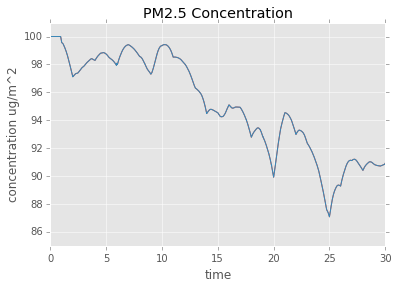

In [777]:
# Plot the concentration

thefig, theAx = plt.subplots(1,1)
theLines = theAx.plot(tvals, cn)
theAx.set_title('PM2.5 Concentration')
theAx.set_xlabel('time')
theAx.set_ylabel('concentration ug/m^2')
theAx.set_ylim([85,101])


plt.plot(tvals,cn)


In [732]:
# some funtions to help with the density

def find_nearest(array,value):
    # finds the nearest value in a given array for a given number
    
    # args:
    #  array: array I want to find value for
    #  value: the value I want to get from array
    
    # returns:
    #  the nearest value in the array to the value specified
    
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def getTime(thres, axes):
    ntime = np.empty_like(newx)
    for i in range(0,len(newx)):
        ntime[i] = timeVals[np.argmax(allx[i,:,axes] > thres)]
    return(ntime)


In [733]:
def getBetween(low,high,time,dr):
    # Produces the number of particles between two boundaries
    
    # Args:
    #   low: the low number
    #   high: the high number
    #   time: the snapshot of the diffusion
    #   dr: the direction, one of
    #     x,y,z
    # returns:
    #     the number of partilcles within the area
    
    # dr is one of 0,1,2
    # 0 = x
    # 1 = y
    # 2 = z
    
    arr = allx[:,time,dr]
    boo = sum((arr > low) * (arr < high))
    return(boo)



50.0
[  0.00000000e+00   1.00000000e-02   2.00000000e-02 ...,   2.99700000e+01
   2.99800000e+01   2.99900000e+01]


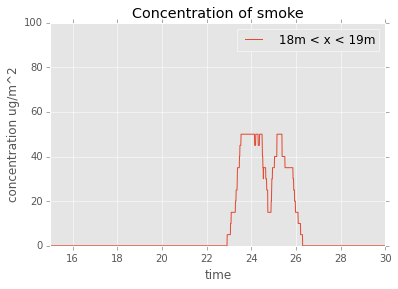

In [766]:

# the concentration in x and z
conx = np.empty_like(timeVals)
conz = np.empty_like(timeVals)

# the time vals are divided by the dt value to get seconds
tvals = timeVals*(1/0.01)

# use getbetween to get the concentration in x and z
for i in range(0,len(tvals)):
      conx[i] = getBetween(18,19,tvals[i],0)
        
for i in range(0,len(tvals)):
      conz[i] = getBetween(0.1,10,tvals[i],2)

# divide by 20 to get the weighted concentration for each partilce
conx = (conx*100)/20
tvals = tvals/100

# plot it
thefig, theAx = plt.subplots(1,1)
theLine1 = theAx.plot(tvals, conx, label=' 18m < x < 19m')
#theLine2 = theAx.plot(tvals, conz, label="yp < 10m")
theAx.set_title('Concentration of smoke')
theAx.set_xlabel('time')
theAx.set_ylabel('concentration ug/m^2')
theAx.set_xlim([15,30])
theAx.set_ylim([0,100])

out=theAx.legend(loc='best')


(16, 20)

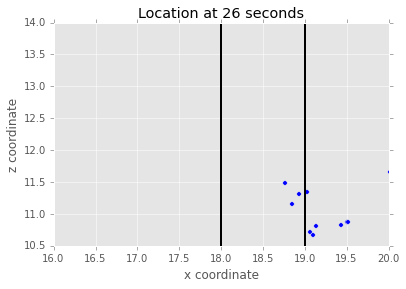

In [765]:
# get scatter plot for specific time

time = 2600

x1 = allx[:,time,0]
y1 = allx[:,time,1]
z1 = allx[:,time,2]


thefig, theAx = plt.subplots(1,1)
theLines = theAx.scatter(x1, z1)
theLine2 = theAx.axvline(x=18., ymin=0., ymax = 30.615, linewidth=2, color='k')
theLine3 = theAx.axvline(x=19., ymin=0., ymax = 30.615, linewidth=2, color='k')
theAx.set_title('Location at 26 seconds')
theAx.set_xlabel('x coordinate')
theAx.set_ylabel('z coordinate')
theAx.set_xlim([16,20])

# thefig, theAx = plt.subplots(1,1)
# theLines = theAx.scatter(x1, y1)
# theAx.set_title('Location at 16 seconds')
# theAx.set_xlabel('x coordinate')
# theAx.set_ylabel('y coordinate')



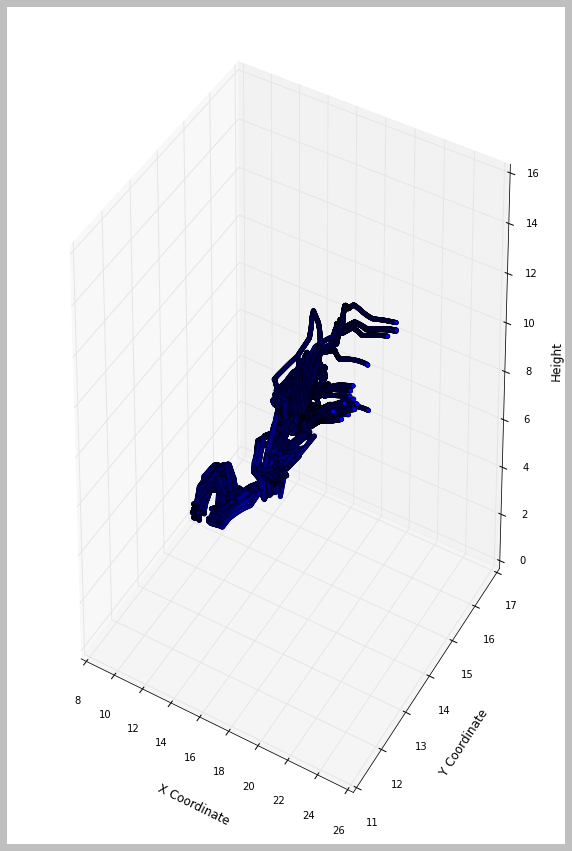

In [736]:
# plot dispersion in 3d

plt.style.use('grayscale')

fig = plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')

for i in range(0,len(newx)):
    xp = allx[i,:,0]
    yp = allx[i,:,1]
    zp = allx[i,:,2]
    ax.scatter(xp, yp, zp)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Height')

#plt.close('all')
#plt.style.use('ggplot')
#fig,ax=plt.subplots(1,1,figsize=(8,8))
#for i in np.arange(0,temp.shape[0],2):
    #theta = make_theta(tempprof[i,:],press)
    #ax.plot(theta,z)
#ax.set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
       #title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')

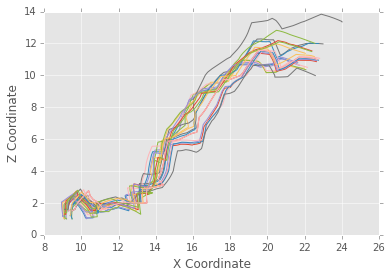

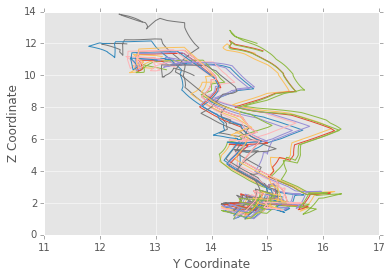

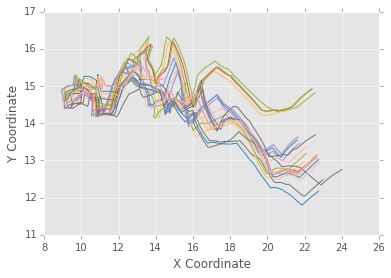

In [737]:
# now make dispersion in 3 2d plots
plt.style.use('ggplot')
plt.close('all')

#xz plot
thefig, theAx = plt.subplots(1,1)
theLines = theAx.plot(xp,zp)
for i in range(0,len(newx)):
    xp = allx[i,:,0]
    zp = allx[i,:,2]
    theAx.plot(xp,zp)
    
theAx.set_xlabel('X Coordinate')
theAx.set_ylabel('Z Coordinate')
#theAx.set_xlim([7,23])


#yz
thefig, theAx = plt.subplots(1,1)
theLines = theAx.plot(yp,zp)
for i in range(0,len(newx)):
    yp = allx[i,:,1]
    zp = allx[i,:,2]
    theAx.plot(yp,zp)   
theAx.set_xlabel('Y Coordinate')
theAx.set_ylabel('Z Coordinate')

#xy
thefig, theAx = plt.subplots(1,1)
theLines = theAx.plot(xp,yp)
for i in range(0,len(newx)):
    xp = allx[i,:,0]
    yp = allx[i,:,1]
    theAx.plot(xp,yp)   
theAx.set_xlabel('X Coordinate')
theAx.set_ylabel('Y Coordinate')
#theAx.set_xlim([7,23])


# thefig, theAx = plt.subplots(1,1)
# theLines = theAx.plot(yVals[:,0], yVals[:,2])
# theAx.set_title('particle path')
# theAx.set_xlabel('x coordinate')
# theAx.set_ylabel('z coordinate')
# #theAx.legend(theLines, ('white daisies', 'black daisies'), loc='best')

# thefig, theAx = plt.subplots(1,1)
# theLines = theAx.plot(yVals[:,1], yVals[:,2])
# theAx.set_title('particle path')
# theAx.set_xlabel('y coordinate')
# theAx.set_ylabel('z coordinate')

# thefig, theAx = plt.subplots(1,1)
# theLines = theAx.plot(yVals[:,0], yVals[:,1])
# theAx.set_title('particle path')
# theAx.set_xlabel('x coordinate')
# theAx.set_ylabel('y coordinate')
# #out=theAx.legend(theLines, ('white errors', 'black errors'), loc='best')

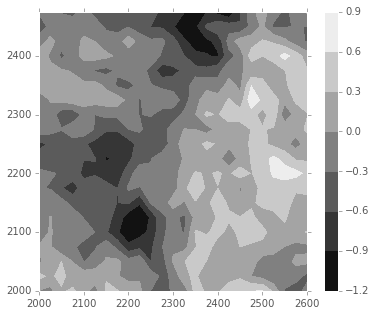

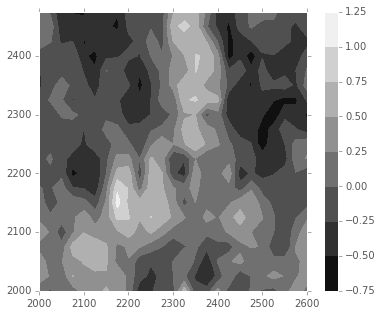

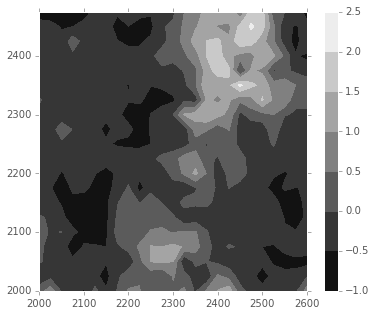

In [740]:
# plot contours, in black and white for reasons I cant understand

plt.style.use('ggplot')

fig,ax = plt.subplots(1,1,figsize=(6,5))
a = ax.contourf(x,y,uvel[10,10,:,:])
#b = ax[1].contourf(x,y,vvel[20,120,:,:])
#c = ax[2].contourf(x,y,wvel[20,120,:,:])

cbar = plt.colorbar(a)

fig,ax = plt.subplots(1,1,figsize=(6,5))
#a = ax.contourf(x,y,uvel[20,10,:,:])
b = ax.contourf(x,y,vvel[10,10,:,:])
#c = ax[2].contourf(x,y,wvel[20,120,:,:])
cbar = plt.colorbar(b)

fig,ax = plt.subplots(1,1,figsize=(6,5))
#a = ax.contourf(x,y,uvel[20,120,:,:])
#b = ax[1].contourf(x,y,vvel[20,120,:,:])
c = ax.contourf(x,y,wvel[10,10,:,:])

cbar = plt.colorbar(c)



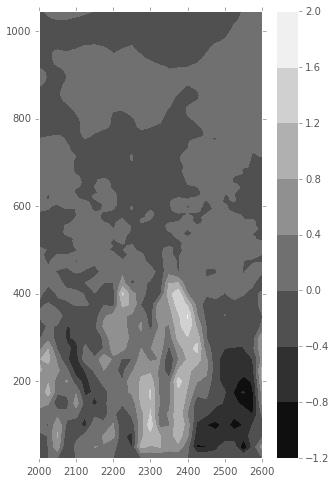

In [741]:

fig,ax = plt.subplots(1,1,figsize=(5,8))
#a = ax.contourf(x,y,uvel[20,120,:,:])
#b = ax[1].contourf(x,y,vvel[20,120,:,:])
c = ax.contourf(x,z,wvel[10,:,0,:])

cbar = plt.colorbar(c)